<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/outliers/01_outliers_values_cut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings

# **Info**

Pagos de Siniestros Realizados por CIIU

Pagos realizados por créditos no pagados (Siniestros) clasificados por CIIU entre el 2009 y el 2018.

Propósito
- Crear técnicas básicas para lidiar con valores atípicos, en el preprocesamiento.

Aspectos

Para cuestiones del ejercicio tomaremos todos los años.
Aplicación del fuzzy
El factor a segmentar ciiu.
path data: https://www.datos.gov.co/Econom-a-y-Finanzas/Pagos-de-Siniestros-Realizados-por-CIIU/t3ws-gv3u

Suministró los datos: Fondo Nacional de Garantías S.A.

# **Config**
---

In [2]:
sns.set(style="darkgrid")
pd.set_option('display.float_format', '{:,.2f}'.format)
warnings.simplefilter("ignore")
title_data = 'Pagos de Siniestros Realizados por CIIU'
paleta = sns.color_palette("tab10").as_hex()

# **Funciones**
---



In [3]:
def null_features_per_record(data, figsize=(9,8), **kwargs):
  """Identifica el número de caracteristicas nulas por registro"""
  plt.figure(figsize=figsize)
  (
      data
      .isnull()
      .transpose()
      .pipe(
          lambda df: (
              sns.heatmap(
                  data = df

              ).set(**kwargs)
          )
      )
  )

# **Data**
---

In [4]:
# Data de los pagos
url='https://drive.google.com/file/d/1ZC4B3iRcuLBQB-dkEJ9-ImH3s9N9kym2/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
data = pd.read_csv(url, dtype=str)

In [5]:
# Conversión tipo de datos
data[['ano', 'siniestros']] = data[['ano', 'siniestros']].astype('int32')
data[['valor']] = data[['valor']].astype('float64')

# **EDA**
---

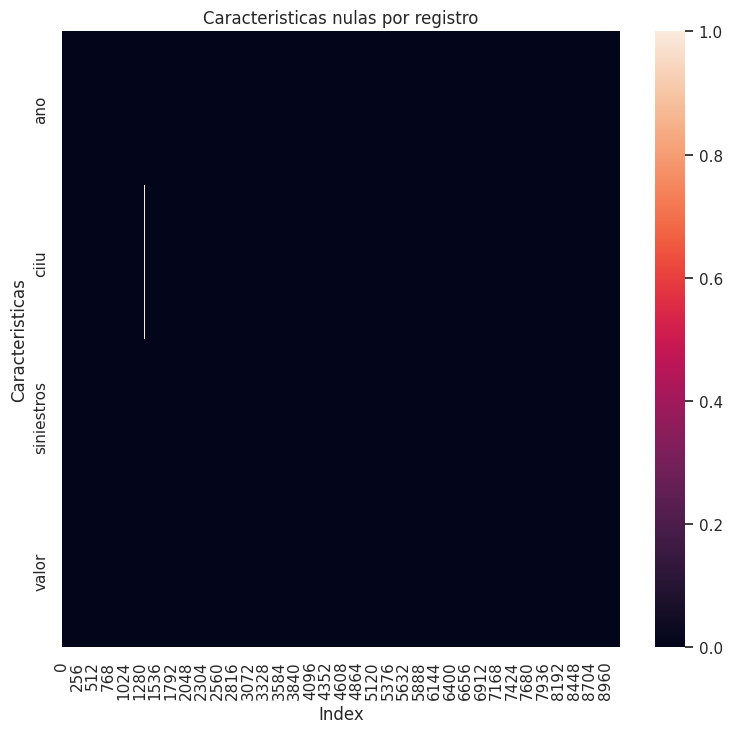

In [6]:
null_features_per_record(
    data,
    title="Caracteristicas nulas por registro",
    xlabel='Index',
    ylabel='Caracteristicas')


In [7]:
data['ciiu'].isnull().sum()

17

- Hay un porcentaje de valores nulos en la columna ciiu, pero es mínimo (17 registros). Se puede imputar o ignorar.

In [8]:
len(data['ano'].unique()), len(data['ciiu'].unique())

(18, 810)

- Hay información de 18 años
- Hay información de 810 actividades economicas

In [9]:
data.columns

Index(['ano', 'ciiu', 'siniestros', 'valor'], dtype='object')

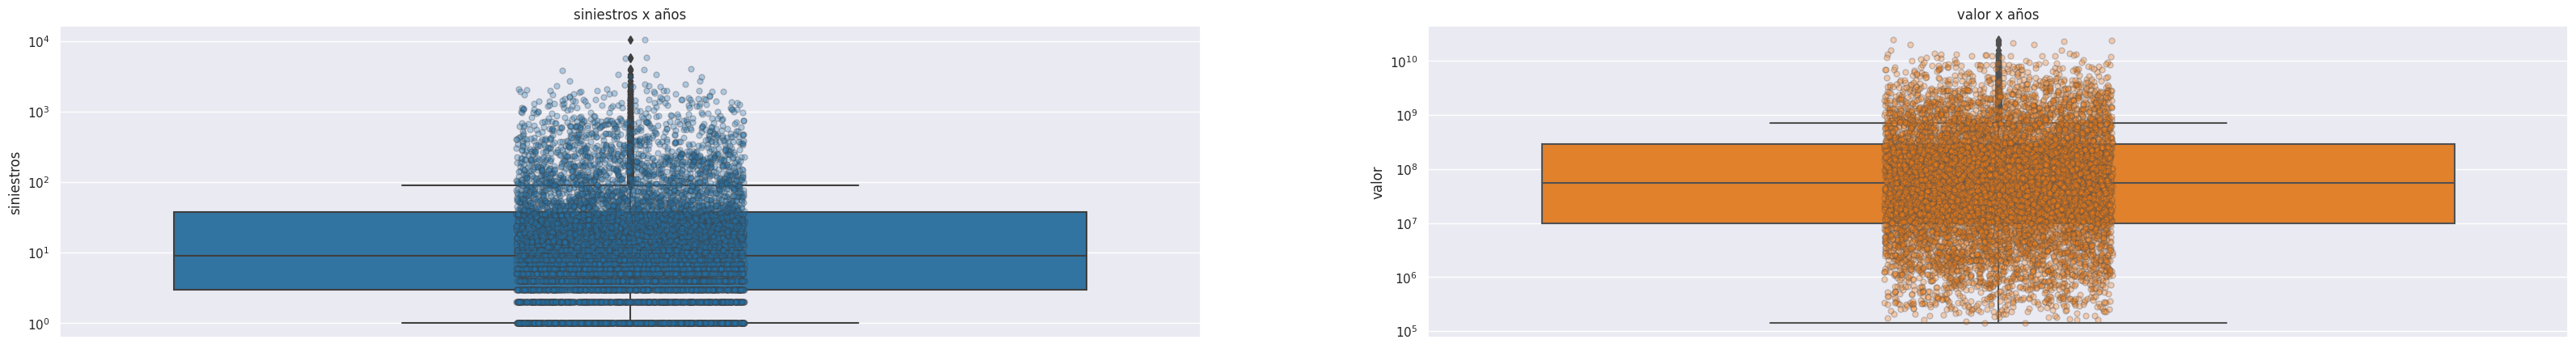

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(40, 5))

sns.boxplot(data=data, y='siniestros', ax=ax[0], color=paleta[0])
sns.stripplot(
    data=data,
    y="siniestros",
    color=paleta[0],
    dodge=True,
    ax=ax[0],
    ec='k',
    linewidth=1,
    alpha = 0.3)

sns.boxplot(data=data, y='valor', ax=ax[1], color=paleta[1])
sns.stripplot(
    data=data,
    y="valor",
    color=paleta[1],
    dodge=True,
    ax=ax[1],
    ec='k',
    linewidth=1,
    alpha = 0.3)

ax[0].set(yscale="log")
ax[0].set_title('siniestros x años')
ax[1].set(yscale="log")
ax[1].set_title('valor x años')

plt.show()

Por el monto total, se aprecia una concentración significativa y uniforme de atípicos en el límite superior, en ambas variables: siniestros y valor.

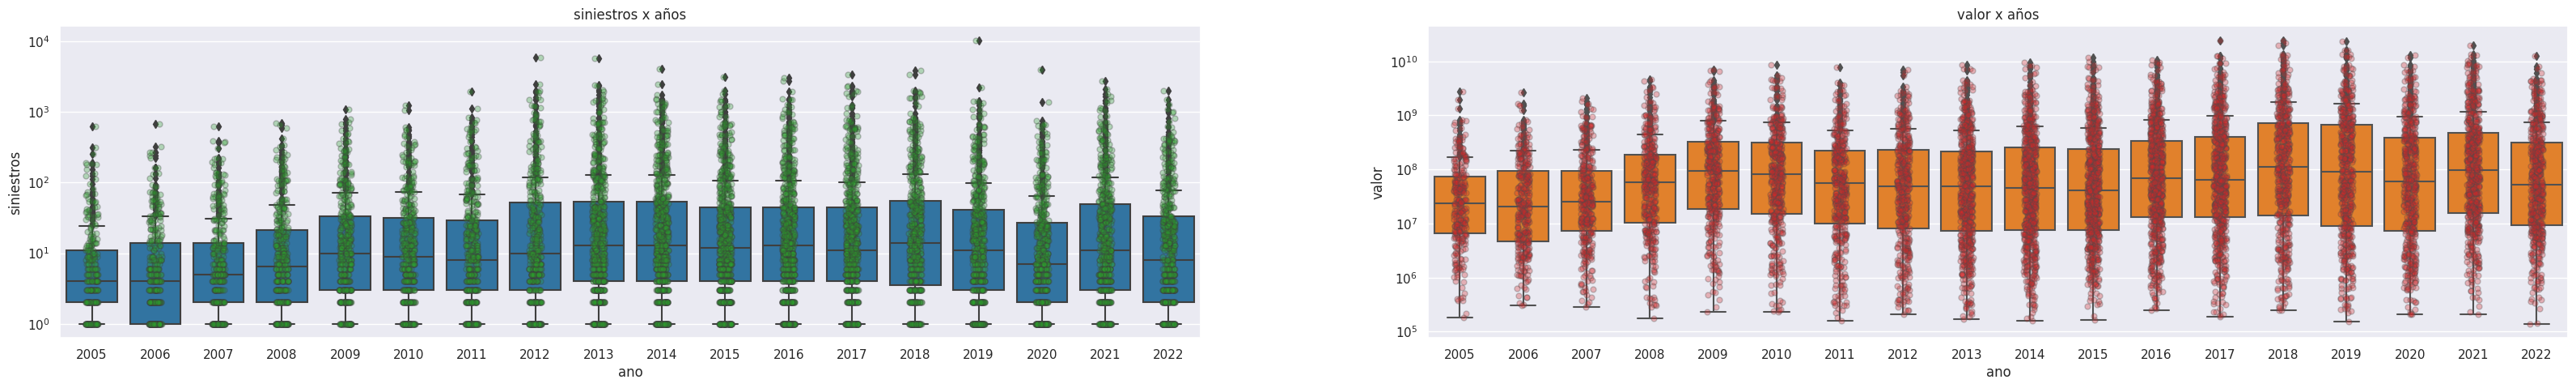

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(40, 5))

sns.boxplot(data=data, x='ano', y='siniestros', ax=ax[0], color=paleta[0])
sns.stripplot(
    data=data,
    y="siniestros",
    x='ano',
    color=paleta[2],
    dodge=True,
    ax=ax[0],
    ec='k',
    linewidth=1,
    alpha = 0.3
    )
ax[0].set_title('siniestros x años')
ax[0].set(yscale="log")
sns.boxplot(data=data, x='ano', y='valor', ax=ax[1], color=paleta[1])
sns.stripplot(
    data=data,
    y="valor",
    x='ano',
    color=paleta[3],
    dodge=True,
    ax=ax[1],
    ec='k',
    linewidth=1,
    alpha = 0.3)

ax[1].set_title('valor x años')
ax[1].set(yscale="log")
plt.show()

Si se separa la concentración por los años, se puede evidenciar que también hay una concentración significativa de atípicos en los limites superiores. Esto tiene sentido, pues sería raro ver un siniestro negativo o su monto, acorde a los datos.

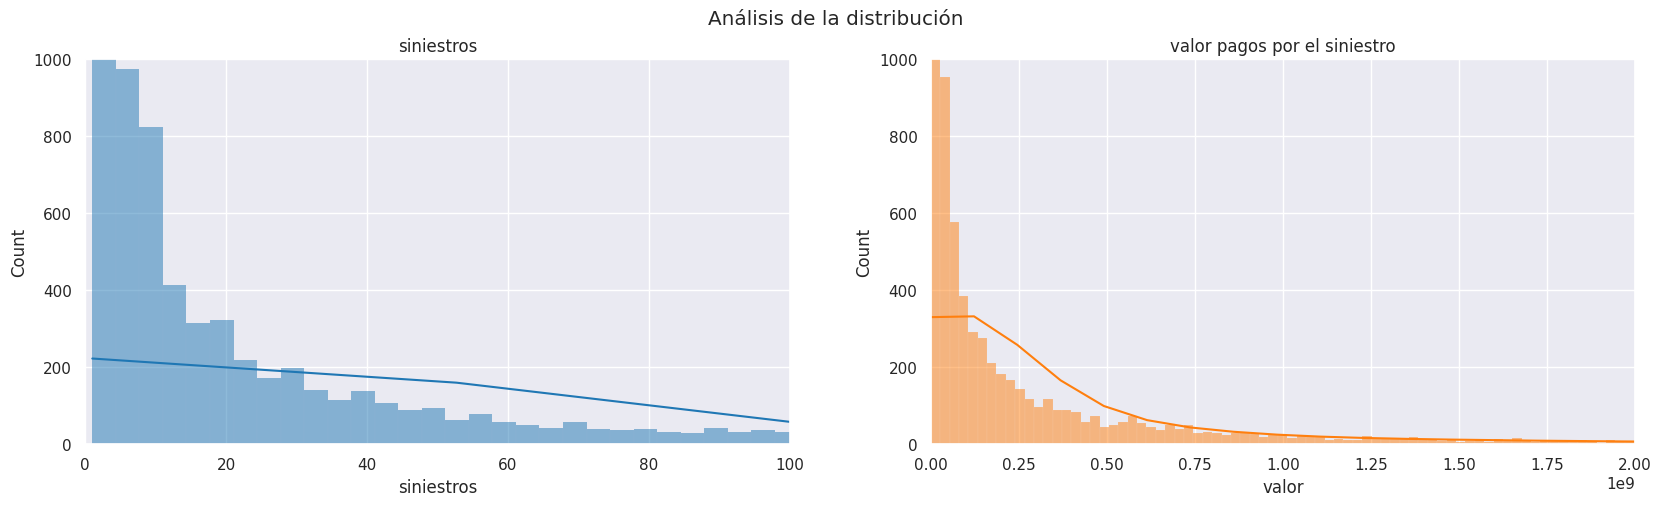

In [12]:
# Analizando la distribución densidad kerne
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(data=data, x='siniestros', kde=True, color=paleta[0], ax=ax[0])
sns.histplot(data=data, x='valor', kde=True, color=paleta[1], ax=ax[1])

# Zoom
ax[0].set_xlim(0,100)
ax[0].set_ylim(0,1000)

ax[1].set_xlim(0,0.2*1e10)
ax[1].set_ylim(0,1000)

# Set the titles of the plots
ax[0].set_title('siniestros')
ax[1].set_title('valor pagos por el siniestro')

fig.suptitle('Análisis de la distribución')

plt.show()

Después de realizar Zoom en la concentración de los datos, se aprecia que existe un sesgo positivo, debido a la naturaleza de los datos, como son el número de siniestro que deben ser valores positivos, de la misma manera el pago de los siniestros.

# **Recorte por desviaciones estandar**
- Se realiza una aplicación del teorema del Chebyshev, la media y las desviaciones.

- Abordaremos el problema con la información del pago de los siniestros, al considerarlo como la variable de mayor importancia. Pues representa los pagos, si bien debe existir una relación con el número de siniestros, es necesario tener mayor información, debido a que las pólizas y el pago de estas no necesariamente son estándares, dependería del contexto.

Supuesto de que los datos tuvieran una normalidad

- Con tres desviaciones tendriamos acumulados aproximadamente  el 99,7% de los datos.
- Con dos desviaciones tendriamos acumulados aproximadamente  el 95,5% de los datos.
- Con una desviacion tendriamos acumulados aproximadamente  el 68,2 % de los datos.

- Con 3 desviaciones es el menos restrictivo con respecto a los datos
- Con 1 desviación es el más restrictivo, ya que estaríamos perdiendo casi el 30% de los datos

In [13]:
n_desviaciones = 1
mean_valor = data['valor'].mean()
std_valor = data['valor'].std()

print(f'Número de desviaciones {n_desviaciones}')
print(f'Media Valor pago siniestros {mean_valor*100}')
print(f'Desviaciones estándar pagos siniestros {std_valor*100}')

Número de desviaciones 1
Media Valor pago siniestros 43482605916.174515
Desviaciones estándar pagos siniestros 130115537666.6036


In [14]:
# Definir los limites

uppder_limit = mean_valor + n_desviaciones * std_valor
lowest_limit = mean_valor - n_desviaciones * std_valor

print(f'Limite superior {uppder_limit}')
print(f'Limite inferior {lowest_limit}')

Limite superior 1735981435.8277812
Limite inferior -866329317.504291


In [15]:
total_row = data.shape[0]
upper_outliers_percentage = data[data['valor'] > uppder_limit].shape[0]
lower_outliers_percentage = data[data['valor'] < lowest_limit].shape[0]

In [16]:
(lower_outliers_percentage / total_row) * 100

0.0

In [17]:
print(
    f"""Porcentaje de atípicos en el límite superior
    { (upper_outliers_percentage / total_row) * 100}"""
)


print(
    f"""Porcentaje de atípicos en el límite inferior
    { (lower_outliers_percentage / total_row) * 100}"""
)

Porcentaje de atípicos en el límite superior
    5.914972273567468
Porcentaje de atípicos en el límite inferior
    0.0


In [18]:
data.shape

(9197, 4)

In [19]:
data_curt = data.copy()
data_curt = data_curt[
    (data_curt['valor']<uppder_limit)
    &
    (data_curt['valor']>lowest_limit)
    ]
data_curt

,ano,ciiu,siniestros,valor
0,2005,10,112,"277,074,887.54"
2,2005,114,2,"47,756,360.00"
3,2005,117,1,"6,940,125.00"
4,2005,122,6,"78,253,979.00"
5,2005,123,8,"25,072,888.00"
...,...,...,...,...
9190,2022,9601,69,"213,630,305.00"
9192,2022,9603,5,"15,426,886.00"
9194,2022,9700,26,"48,770,918.00"
9195,2022,9810,1,"643,814.00"


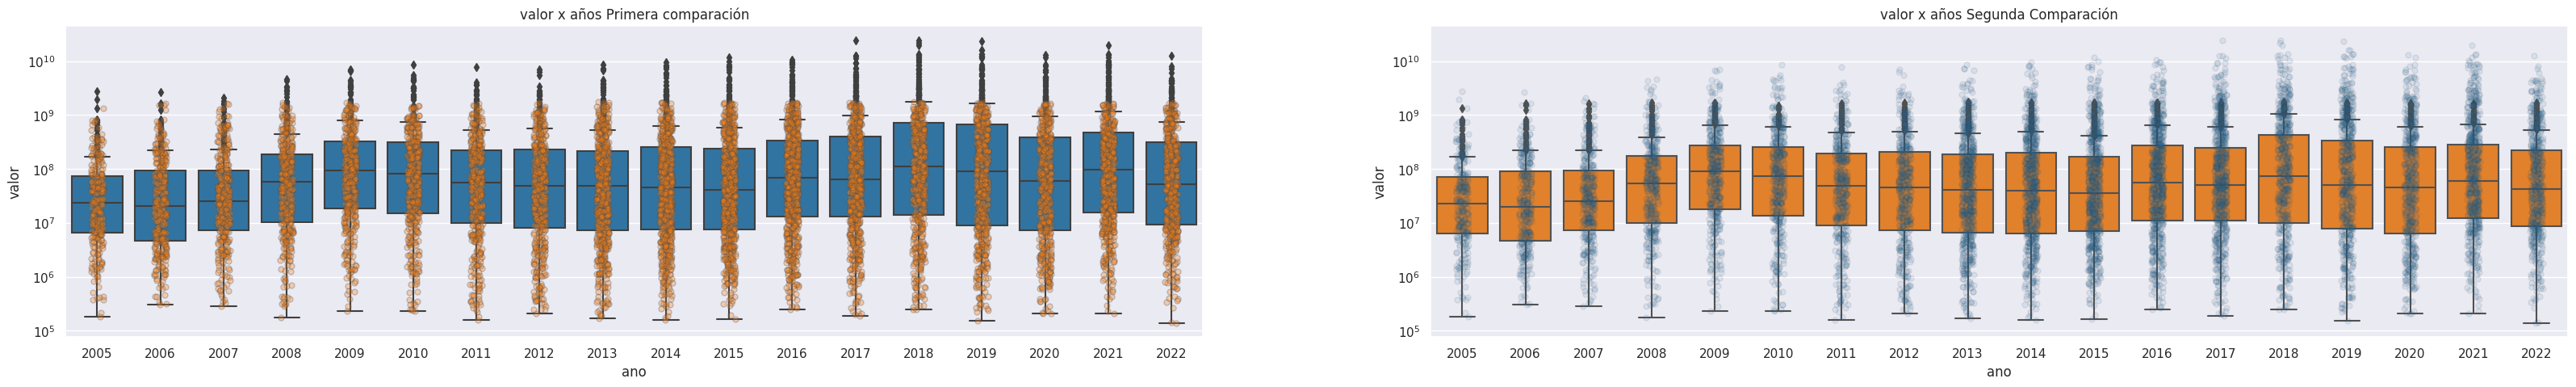

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(40, 5))

sns.boxplot(data=data, x='ano', y='valor', ax=ax[0], color=paleta[0])
sns.stripplot(
    data=data_curt,
    y="valor",
    x='ano',
    color=paleta[1],
    dodge=True,
    ax=ax[0],
    ec='k',
    linewidth=1,
    alpha = 0.3
    )
ax[0].set_title('valor x años Primera comparación')
ax[0].set(yscale="log")

sns.boxplot(data=data_curt, x='ano', y='valor', ax=ax[1], color=paleta[1])
sns.stripplot(
    data=data,
    y="valor",
    x='ano',
    color=paleta[0],
    dodge=True,
    ax=ax[1],
    ec='k',
    linewidth=1,
    alpha = 0.1
    )
ax[1].set_title('valor x años Segunda Comparación')
ax[1].set(yscale="log")

plt.show()

- Se aprecia que los atípicos reducieron, en comparación a la distribución original, con un aproximadamente el 6% de perdida de los datos.

In [21]:
data_curt['tratado'] = 1
data['tratado'] = 0

In [22]:
data_suprema = pd.concat([data_curt,data], axis = 0)
data_suprema

,ano,ciiu,siniestros,valor,tratado
0,2005,10,112,"277,074,887.54",1
2,2005,114,2,"47,756,360.00",1
3,2005,117,1,"6,940,125.00",1
4,2005,122,6,"78,253,979.00",1
5,2005,123,8,"25,072,888.00",1
...,...,...,...,...,...
9192,2022,9603,5,"15,426,886.00",0
9193,2022,9609,398,"7,176,019,083.00",0
9194,2022,9700,26,"48,770,918.00",0
9195,2022,9810,1,"643,814.00",0


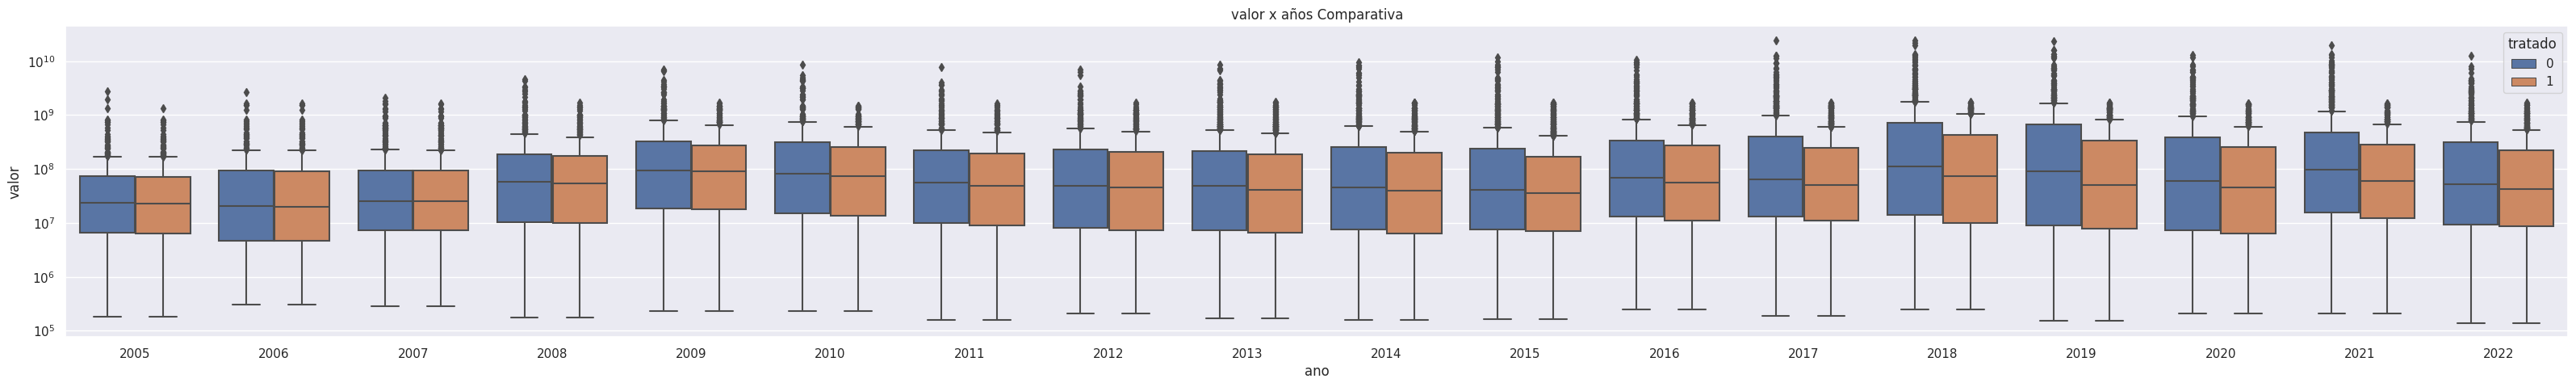

In [24]:
fig, ax = plt.subplots(figsize=(40, 5))

sns.boxplot(data=data_suprema, x='ano', y='valor', hue='tratado')
ax.set_title('valor x años Comparativa')
ax.set(yscale="log")
plt.show()

Como se aprecia el conjunto de datos tratados con la etiqueta, uno redujo los atípico, en comparación con la data sin tratar (etiqueta cero). Lo otro que se debe destacar es que la distribución de los datos tratados sufrió un ajuste en la distribución, pero no con un impacto significativo, sobre todo en las concentraciones, ya que estas son muy similares a las originales, esto se acentúa en los años donde los atípicos desaparecieron como los del 2018 hasta 2022.